In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [2]:
# IMAGE_PATH = '../input/sentinel2d700/data/JPG/'
# MASK_PATH = '../input/sentinel2d700/data/PNG/'

IMAGE_PATH = '/home/shrayank_mistry/Modules/Rasters/data/JPG/'
MASK_PATH = '/home/shrayank_mistry/Modules/Rasters/data/PNG/'

# IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
# MASK_PATH =  '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [3]:
n_classes = 4

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  201


In [4]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  153
Val Size     :  27
Test Size    :  21


Image Size (20976, 10980, 3)
Mask Size (20976, 10980)


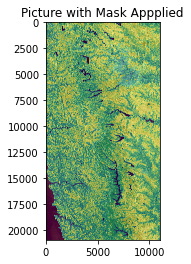

In [5]:
img = Image.open(IMAGE_PATH + df['id'][11] + '.png')
mask = Image.open(MASK_PATH + df['id'][11] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        
        # Normalize the mask between 0 - 1
        mask = mask / 255
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 1 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [8]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [9]:
def plot_loss(history, model_name):
    plt.figure(figsize = (5, 5), dpi = 125)
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.savefig(f'{model_name}-Loss.jpg', bbox_inches = 'tight')
    plt.show()
    
def plot_score(history, model_name):
    plt.figure(figsize = (5, 5), dpi = 125)
    plt.plot(history['train_miou'], label='train_mIoU', marker='.')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='.')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.savefig(f'{model_name}-Mean IoU.jpg',bbox_inches = 'tight')
    plt.show()
    
def plot_acc(history, model_name):
    plt.figure(figsize = (5, 5), dpi = 125)
    plt.plot(history['train_acc'], label='train_accuracy', marker='p')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='p')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.savefig(f'{model_name}-Accuracy.jpg', bbox_inches = 'tight')
    plt.show()

In [10]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [11]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [12]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # print(image.shape)
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [13]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        # print(output.shape)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc


In [14]:
def train_model(model, epochs):
    max_lr = 1e-3
    epoch = epochs
    weight_decay = 1e-4

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

    history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
    return history

In [27]:
X_test = list(X_test)
X_test = np.array(['C_201'])

In [28]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
# t_test = A.Resize(1000, 1000, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [19]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
CLASSES = 4
ENCODER_DEPTH = 5
DECODER_CHANNELS = [256, 128, 64, 32, 16]

unet_resnet50 = smp.Unet(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = CLASSES, 
    activation = ACTIVATION, 
    encoder_depth = ENCODER_DEPTH, 
    decoder_channels = DECODER_CHANNELS)

In [20]:
ENCODER = 'vgg11'
ENCODER_DEPTH = 3
ENCODER_WEIGHTS = 'imagenet'
PSP_USE_BATCHNORM = False
CLASSES = 4
ACTIVATION = None

pspnet_vgg11 = smp.PSPNet(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = CLASSES, 
    activation = ACTIVATION, 
    encoder_depth = ENCODER_DEPTH, 
    psp_use_batchnorm = PSP_USE_BATCHNORM)

In [21]:
model_names = ['Unet-resnet50', 'PSPNet-vgg11']
models = [unet_resnet50, pspnet_vgg11]

In [64]:
index = 0
epochs = 2
history = []
for model in models:
    history.append(train_model(models[index], epochs))
    torch.save(model, f'{model_names[index]}_model.pt')
    index = index + 1

100%|██████████| 27/27 [00:47<00:00,  1.74s/it]


Loss Decreasing.. inf >> 0.762 
Epoch:1/2.. Train Loss: 0.698.. Val Loss: 0.762.. Train mIoU:0.653.. Val mIoU: 0.770.. Train Acc:0.746.. Val Acc:0.863.. Time: 15.12m


100%|██████████| 27/27 [00:46<00:00,  1.73s/it]


Loss Decreasing.. 0.762 >> 0.382 
Epoch:2/2.. Train Loss: 0.336.. Val Loss: 0.382.. Train mIoU:0.781.. Val mIoU: 0.751.. Train Acc:0.872.. Val Acc:0.845.. Time: 13.70m
Total time: 28.81 m


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


Loss Decreasing.. inf >> 0.818 
Epoch:1/2.. Train Loss: 0.996.. Val Loss: 0.818.. Train mIoU:0.491.. Val mIoU: 0.182.. Train Acc:0.650.. Val Acc:0.365.. Time: 9.57m


100%|██████████| 27/27 [00:39<00:00,  1.48s/it]

Loss Decreasing.. 0.818 >> 0.419 
Epoch:2/2.. Train Loss: 0.498.. Val Loss: 0.419.. Train mIoU:0.539.. Val mIoU: 0.638.. Train Acc:0.703.. Val Acc:0.775.. Time: 9.09m
Total time: 18.66 m


In [65]:
histarr = np.array(history)

Loss, Score, Accuracy for Model = Unet-resnet50


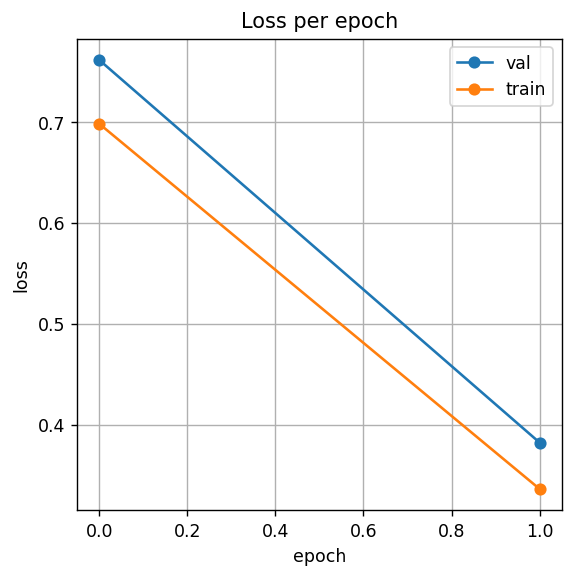

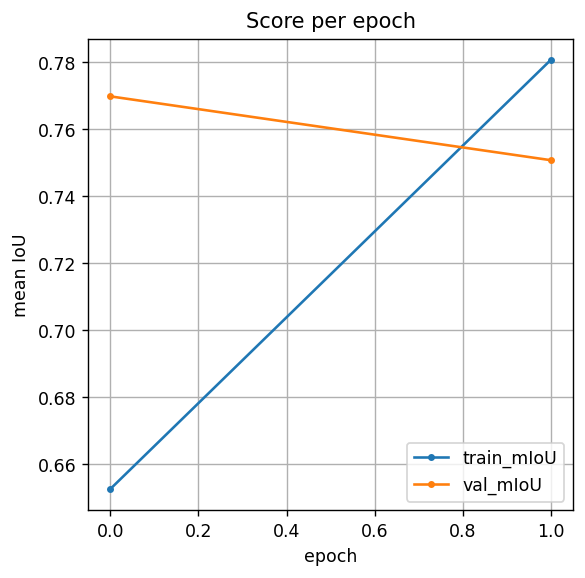

Exception ignored in: <bound method tqdm.__del__ of <tqdm.notebook.tqdm_notebook object at 0x7fd78d61cda0>>
Traceback (most recent call last):
  File "/home/shrayank_mistry/Modules/virtualenv/lib/python3.6/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/shrayank_mistry/Modules/virtualenv/lib/python3.6/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


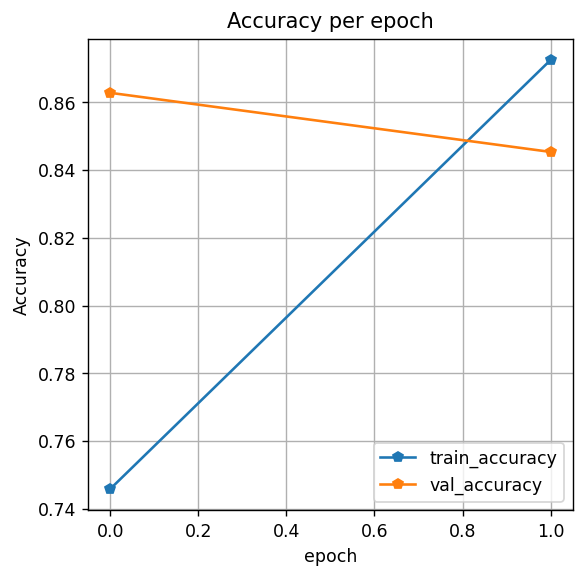

Loss, Score, Accuracy for Model = PSPNet-vgg11


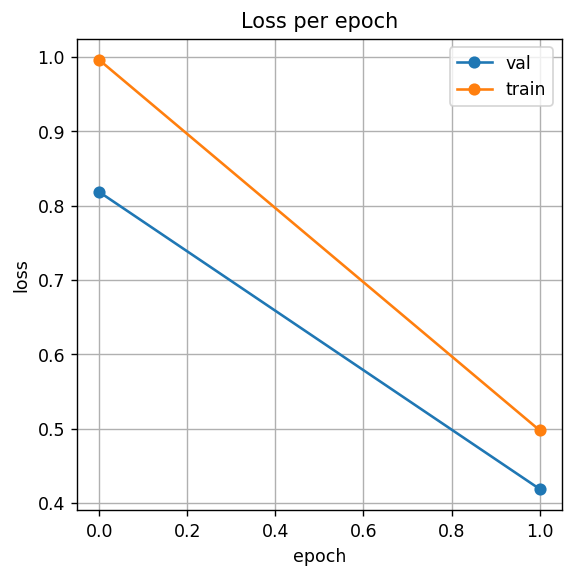

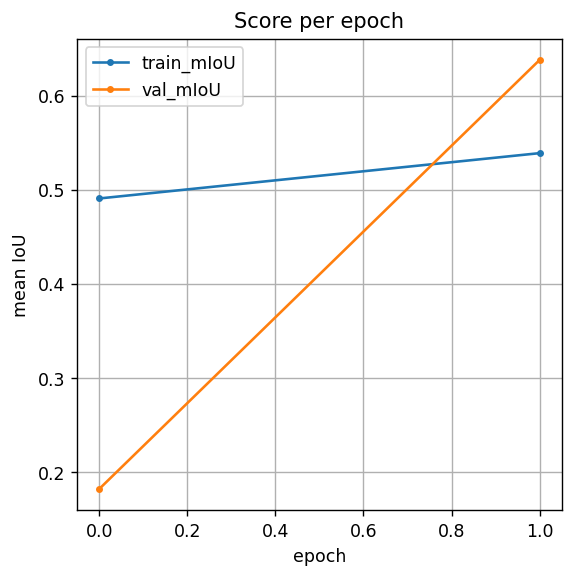

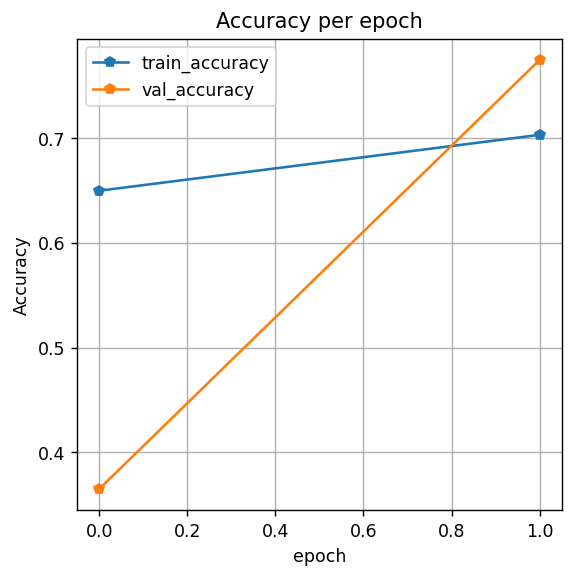

In [66]:
index = 0
for hist in history:
    print(f"Loss, Score, Accuracy for Model = {model_names[index]}")
    plot_loss(hist, model_names[index])
    plot_score(hist, model_names[index])
    plot_acc(hist, model_names[index])
    index = index + 1

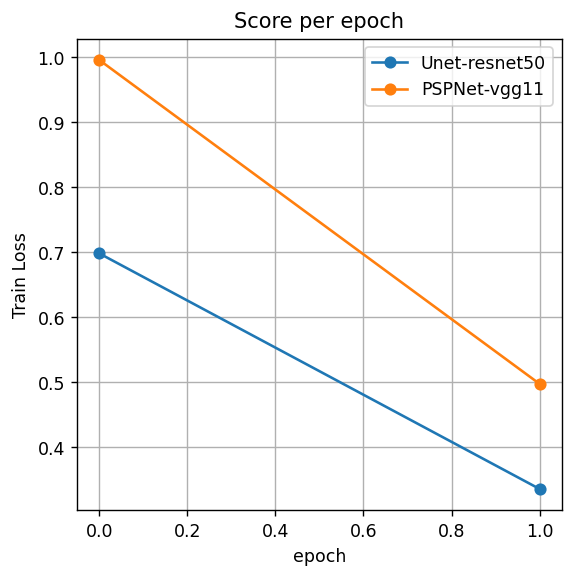

In [67]:
i = 0
plt.figure(figsize = (5, 5), dpi = 125)
for model in models:
    plt.plot(histarr[i]['train_loss'], marker='o')
    i = i + 1
plt.title('Score per epoch'); plt.ylabel('Train Loss')
plt.xlabel('epoch')
plt.legend(labels = model_names), plt.grid()
plt.savefig('Train_Loss_Comparison.jpg', bbox_inches = 'tight')
plt.show()

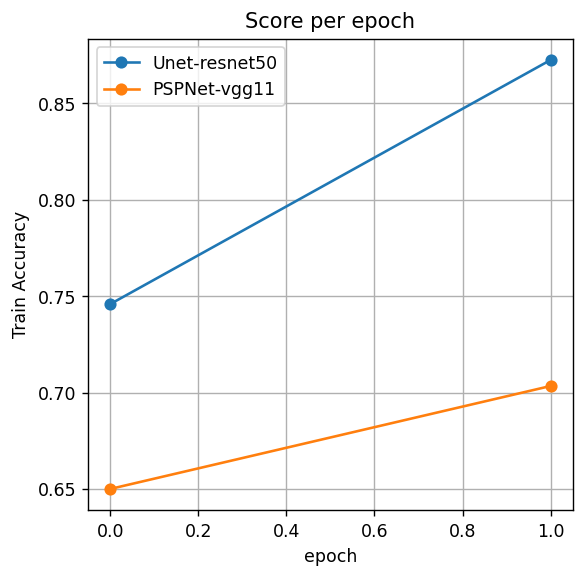

In [68]:
i = 0
plt.figure(figsize = (5, 5), dpi = 125)
for model in models:
    plt.plot(histarr[i]['train_acc'], marker='o')
    i = i + 1
plt.title('Score per epoch'); plt.ylabel('Train Accuracy')
plt.xlabel('epoch')
plt.legend(labels = model_names), plt.grid()
plt.savefig('Train_Accuracy_Comparison.jpg', bbox_inches = 'tight')
plt.show()

In [73]:
miou = []
acc = []
for model in models:
    mob_miou = miou_score(model, test_set)
    mob_acc = pixel_acc(model, test_set)
    miou.append(np.mean(mob_miou))
    acc.append(np.mean(mob_acc))
    print('Test Set mIoU', np.mean(mob_miou))
    print('Test Set Pixel Accuracy', np.mean(mob_acc))

100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Test Set mIoU 0.3185138509721236
Test Set Pixel Accuracy 0.24530063205295138


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]

Test Set mIoU 0.37456708631122415
Test Set Pixel Accuracy 0.212823486328125


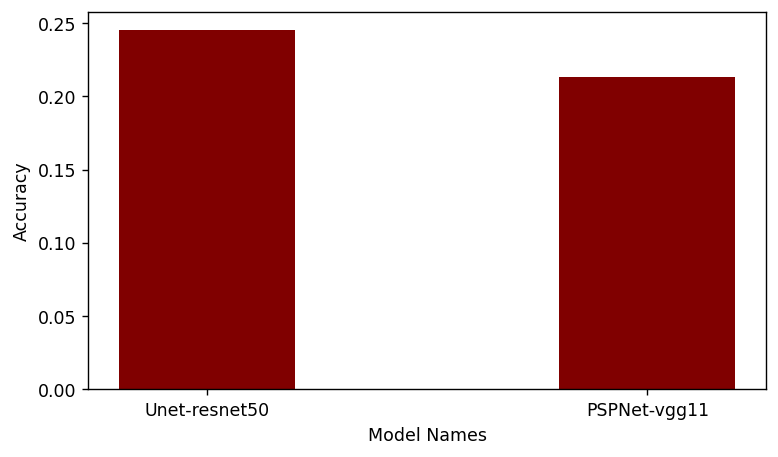

In [74]:
plt.figure(figsize = (7, 4), dpi = 125)
plt.bar(model_names, acc, color ='maroon',width = 0.4)
plt.xlabel('Model Names')
plt.ylabel('Accuracy')
plt.savefig('Model_Accuracy_Comparison.jpg', bbox_inches = 'tight')

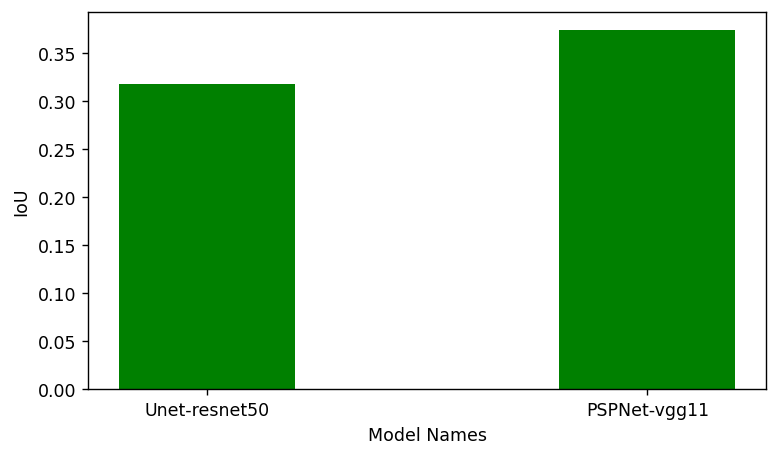

In [75]:
plt.figure(figsize = (7, 4), dpi = 125)
plt.bar(model_names, miou, color ='green',width = 0.4)
plt.xlabel('Model Names')
plt.ylabel('IoU')
plt.savefig('Model_IoU_Comparison.jpg', bbox_inches='tight')

In [29]:
models_loaded = []
for model in model_names:
    t_model = torch.load(f'./{model}_model.pt')
    models_loaded.append(t_model)

In [30]:
test_set[0]

(<PIL.Image.Image image mode=RGB size=1152x768 at 0x7F1AC803AEB8>,
 tensor([[  0,   0,   0,  ..., 255,  85, 170],
         [  0,   0,   0,  ..., 170,  85, 170],
         [  0,   0,   0,  ..., 170, 170, 170],
         ...,
         [  0,   0,   0,  ...,  85,  85, 255],
         [  0,   0,   0,  ...,  85,  85, 170],
         [  0,   0,   0,  ..., 170,  85, 170]]))

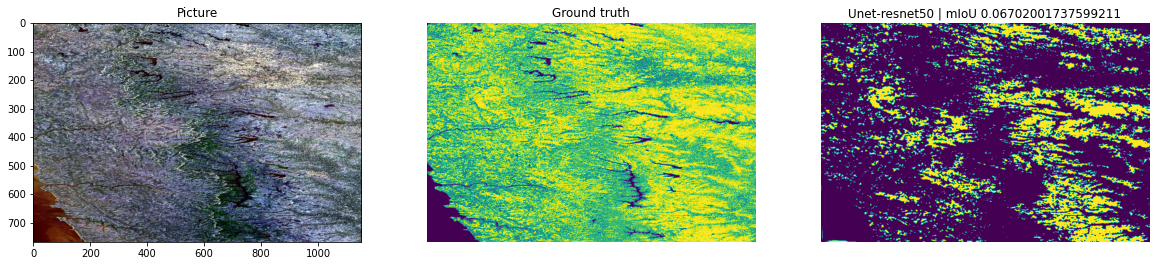

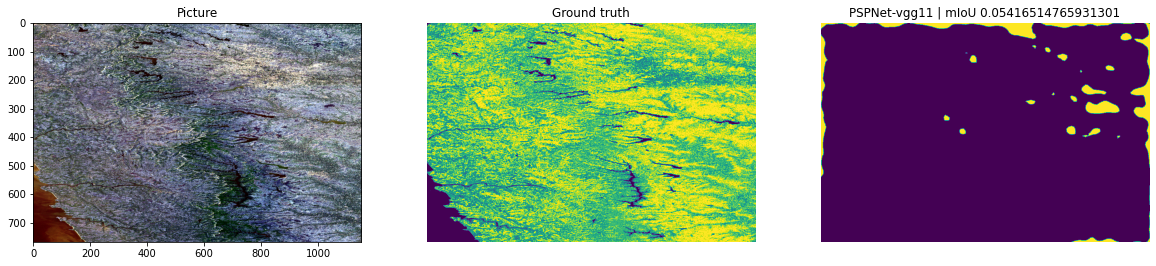

In [31]:
index = 0
for model in models_loaded:
    image, mask = test_set[0]
    pred_mask, score = predict_image_mask_miou(model, image, mask)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Picture');

    ax2.imshow(mask)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(pred_mask)
    ax3.set_title(f'{model_names[index]} | mIoU {score}')
    ax3.set_axis_off()
    
    plt.savefig(f'{model_names[index]}_predict.jpg', bbox_inches = 'tight')
    index = index + 1